**Nombre:** Pablo Alejandro Aguirre Higuera

**Matrícula:** 263845

**Práctica #26: Validación, Evaluación y Selección**

07/11/2025

#### **1. Carga de Bibliotecas y de Datos**

In [117]:
pip install ucimlrepo #Instalar el conjunto de datos

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#Instalar': Expected package name at the start of dependency specifier
    #Instalar
    ^


In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from ucimlrepo import fetch_ucirepo 
  
# El dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# Los Datos
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 
  
# metadata 
print(X)
print(y)

     Gender  Age_at_diagnosis                       Race  ...  IDH2  FAT4  PDGFRA
0         0             51.30                      white  ...     0     0       0
1         0             38.72                      white  ...     0     0       0
2         0             35.17                      white  ...     0     0       0
3         1             32.78                      white  ...     0     1       0
4         0             31.51                      white  ...     0     0       0
..      ...               ...                        ...  ...   ...   ...     ...
834       1             77.89                      white  ...     0     0       0
835       0             85.18                      white  ...     0     0       0
836       1             77.49                      white  ...     0     0       0
837       0             63.33                      white  ...     0     0       0
838       0             76.61  black or african american  ...     0     0       0

[839 rows x 23 

#### **2. Análisis Exploratorio de Datos**

Se tienen 839 observaciones y 23 variables independientes. Grade es la variable de salida.

In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            839 non-null    int64  
 1   Age_at_diagnosis  839 non-null    float64
 2   Race              839 non-null    object 
 3   IDH1              839 non-null    int64  
 4   TP53              839 non-null    int64  
 5   ATRX              839 non-null    int64  
 6   PTEN              839 non-null    int64  
 7   EGFR              839 non-null    int64  
 8   CIC               839 non-null    int64  
 9   MUC16             839 non-null    int64  
 10  PIK3CA            839 non-null    int64  
 11  NF1               839 non-null    int64  
 12  PIK3R1            839 non-null    int64  
 13  FUBP1             839 non-null    int64  
 14  RB1               839 non-null    int64  
 15  NOTCH1            839 non-null    int64  
 16  BCOR              839 non-null    int64  
 1

No se tienen valores faltantes y se las variables tienen el tipo de dato adecuado. Ojo: Si bien el género se podría ver como variable categórica, se dejará como variable de tipo entero para considerar géneros fluidos y todos los habidos y por haber.

In [120]:
X.describe()

,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
count,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000
mean,0.418355,50.935411,0.481526,0.414779,0.258641,0.168057,0.133492,0.132300,0.116806,0.087008,0.079857,0.064362,0.053635,0.047676,0.045292,0.034565,0.032181,0.032181,0.032181,0.027414,0.027414,0.026222
std,0.493583,15.702339,0.499957,0.492978,0.438149,0.374140,0.340309,0.339019,0.321380,0.282015,0.271233,0.245544,0.225431,0.213206,0.208068,0.182784,0.176586,0.176586,0.176586,0.163383,0.163383,0.159889
min,0.000000,14.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.055000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,51.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,62.800000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,89.290000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Todo parece indicar que en este conjunto solamente están los géneros 0 y 1, siendo el 1 el género minoritario. Todas las demás variables numéricas tienen valores entre 0 y 1, entre las cuales IDH1 y TP53 tienen señales de un sesgo considerable a la derecha.

In [121]:
y.value_counts()

Grade
0        487
1        352
Name: count, dtype: int64

Hay un desbalance de clases. La clase 1 tiene un 28% menos de observaciones que su contraparte.

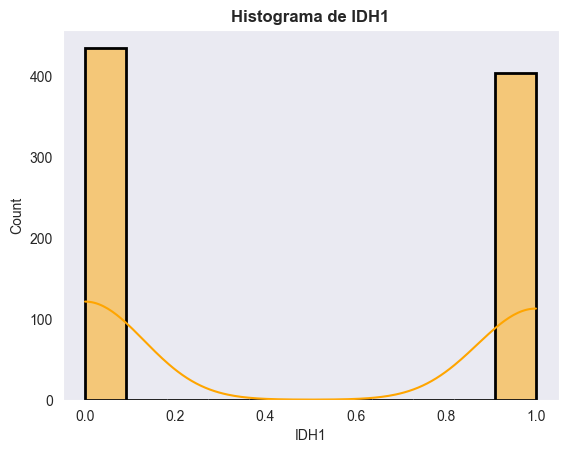

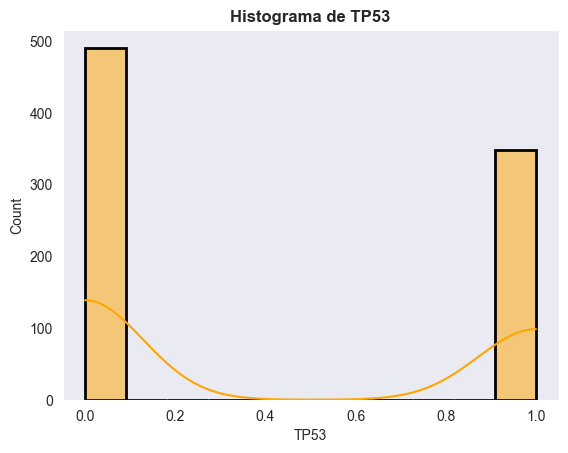

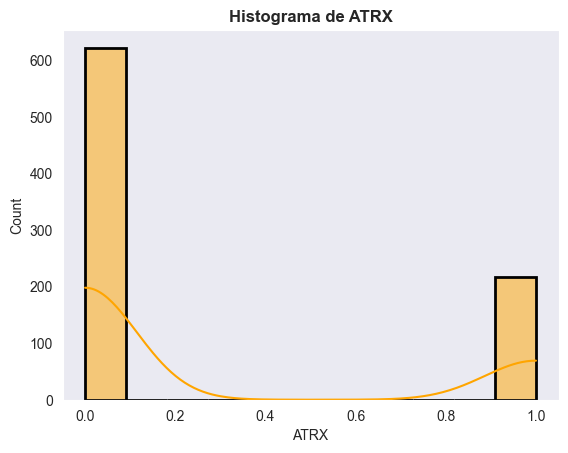

In [122]:
variables = ['IDH1', 'TP53', 'ATRX']
sns.set_style("dark")

for v in variables:
    
    sns.histplot(x=X[v], kde=True, color="orange", linewidth=2, edgecolor="black")
    plt.title(f"Histograma de {v}", fontweight="bold")
    plt.show()

Contrario a lo que se pensaba con los resultados de *describe()*, las variables observadas con un histograma toman ya sea un valor de 0 o de 1.

C:\Users\pablo\AppData\Local\Temp\ipykernel_7516\1990409350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grade'] = y


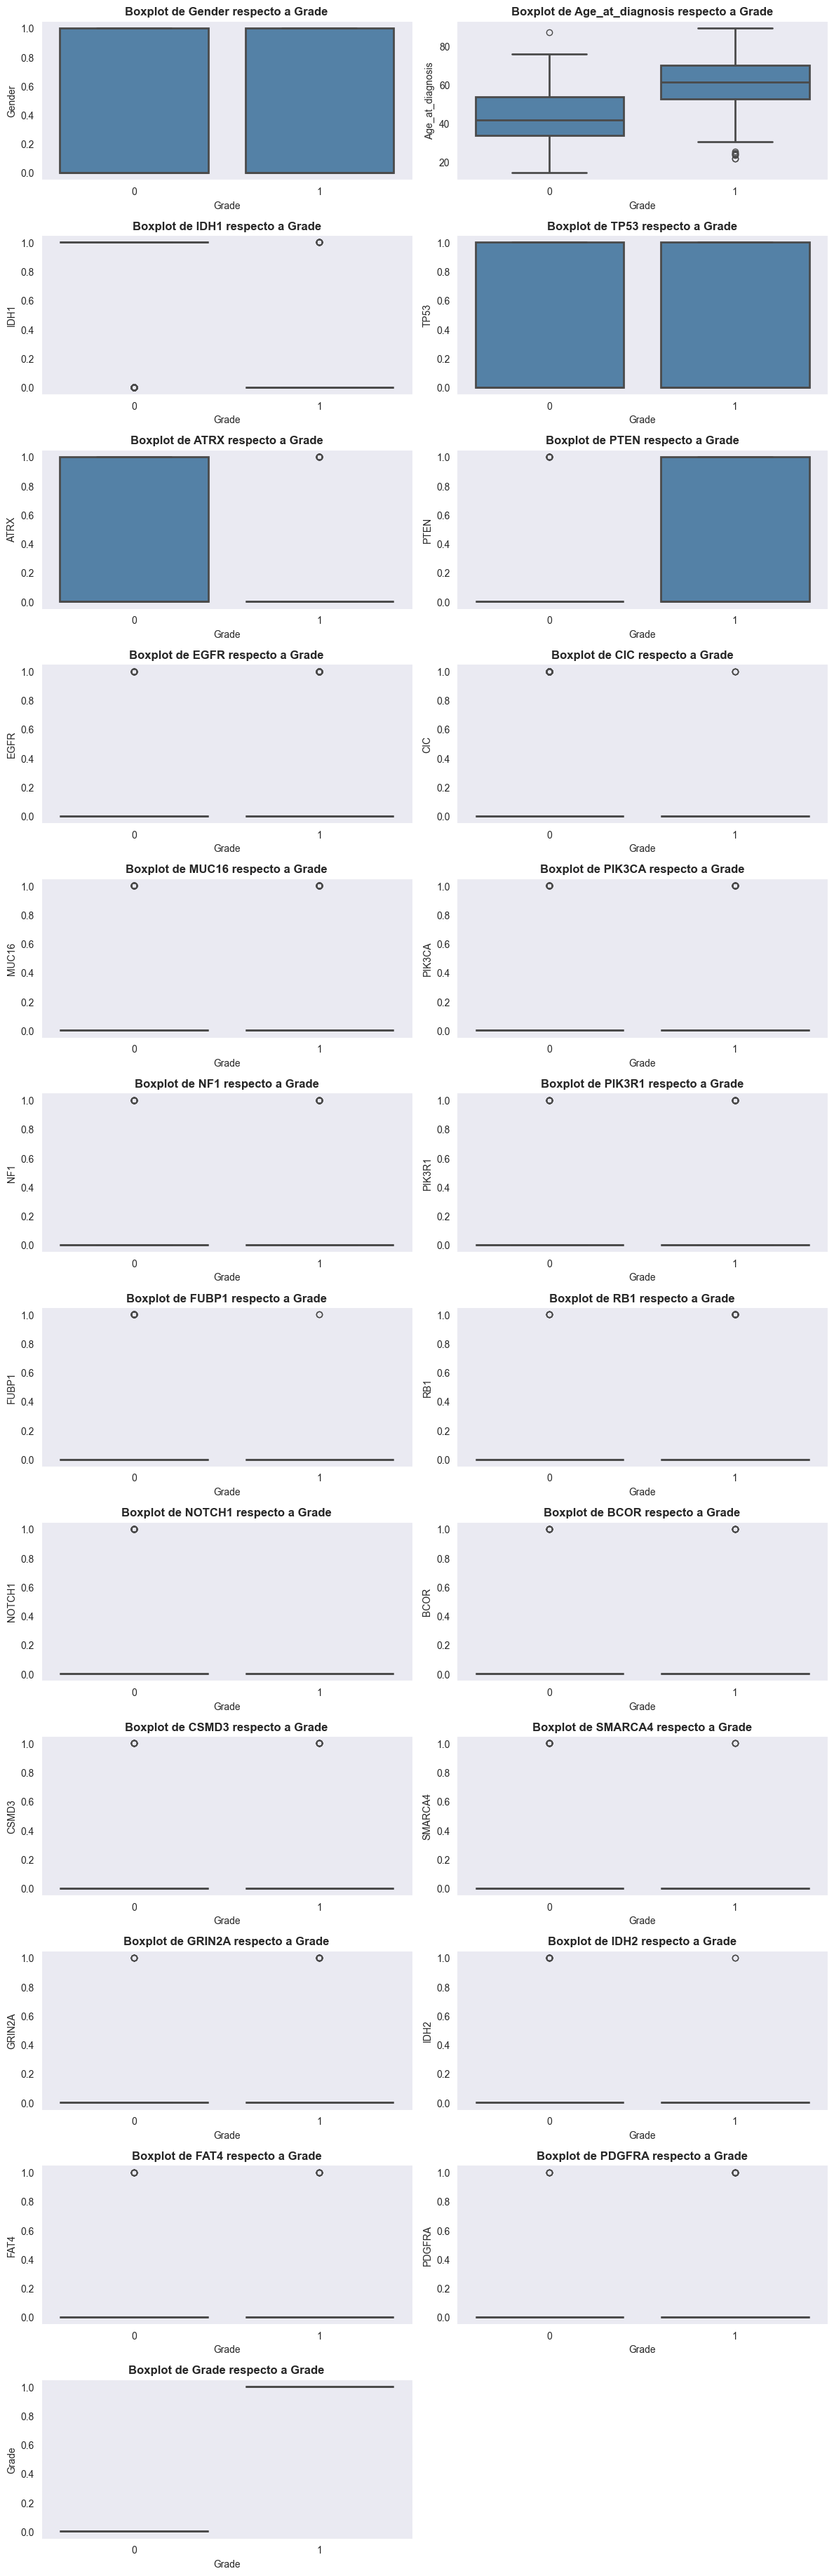

In [123]:
#Concatenar el df de variables X con la variable y
df = X
df['Grade'] = y

num_cols = df.select_dtypes(include=[int, float]).columns
plt.figure(figsize=(12, 70))

for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, i)
    sns.boxplot(x='Grade', y=col, data=df, color="steelblue", linewidth=2)
    plt.title(f"Boxplot de {col} respecto a Grade", fontweight="bold")
    
    plt.xlabel("Grade")
    plt.ylabel(col)
    
plt.tight_layout()
plt.show()



De acuerdo con los gráficos de caja, se puede apreciar una diferencia notable en las variables IDH1 y la edad entre Grade 0 y Grade 1.

In [124]:
df['Race'].value_counts()

Race
white                               765
black or african american            59
asian                                14
american indian or alaska native      1
Name: count, dtype: int64

Dado que solamente hay 4 categorías de raza en los datos, es bastante razonable emplear one hot encoder para transformarlas a numéricas.

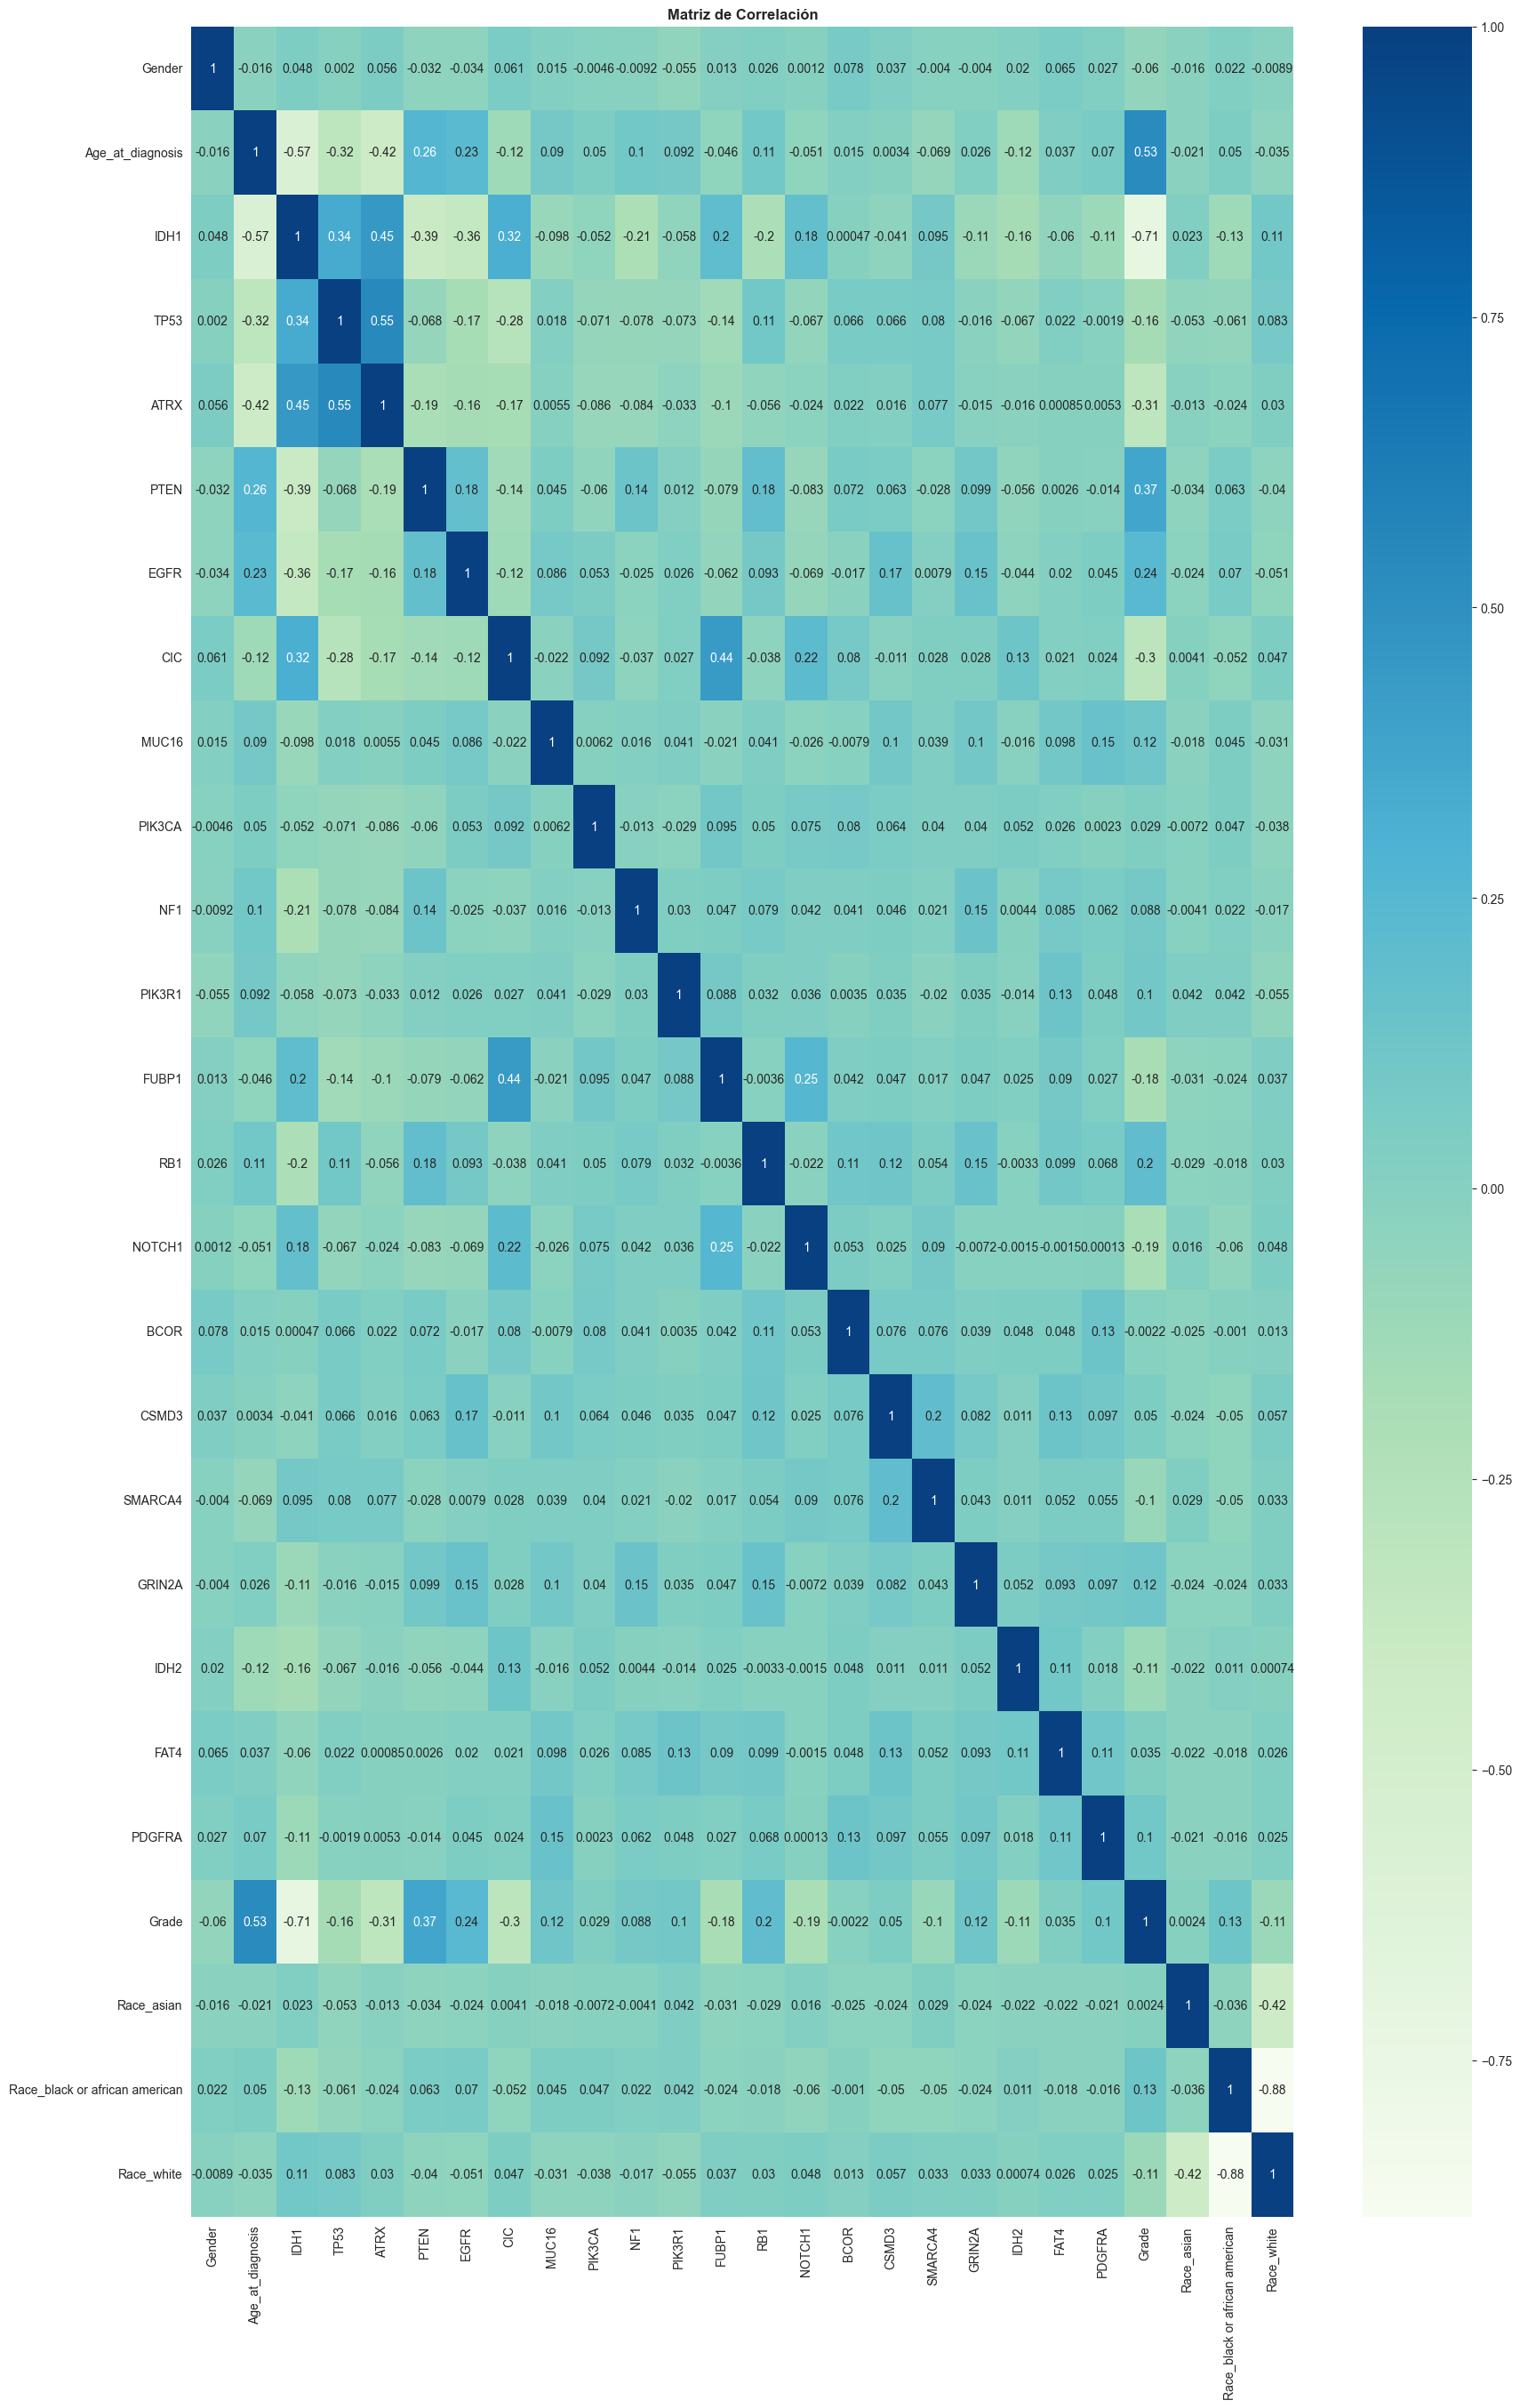

In [125]:
df_encoded = pd.get_dummies(df, columns=['Race'], drop_first=True)
matriz_corr = df_encoded.corr()
plt.figure(figsize=(20, 32))

sns.heatmap(matriz_corr, annot=True, cbar=True, cmap="GnBu")
plt.title("Matriz de Correlación", fontweight="bold")
plt.show()

Con la matriz de correlación, se tiene que: la edad, IDH1, ATRX, PTEN y EGFR son las variables con mayor capacidad explicativa en Grade. Siendo que la diferencia de medias fue más notable en la edad e IDH1 en los boxplots, no sorprende que estas 2 variables sean las de mayor importancia en la matriz de corrleación. La raza no tiene un impacto significativo en Grade.

#### **3. Gráfica de Errores en Entrenamiento y Prueba**

In [126]:
cols_incluir = ['IDH1', 'ATRX', 'PTEN', 'EGFR', 'Age_at_diagnosis', 'Grade']
df = df.loc[:, df.columns.isin(cols_incluir)] #Se quedan solamente las variables más significativas

X = df.drop(columns=['Grade'])
y = df["Grade"]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
prof = [2, 5, 10, 15, 20, 25, 30, None]

train_scores = []
test_scores = []

for i in prof:

    for train_index, test_index in skf.split(X, y):
        # Dividir los datos
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        arbol = DecisionTreeClassifier(random_state=3, max_depth=i)
        arbol.fit(X_train, y_train)

        train_scores.append(cross_val_score(estimator=arbol, X=X_train, y=arbol.predict(X_train), cv=10, scoring='f1_macro'))
        test_scores.append(cross_val_score(estimator=arbol, X=X_test, y=arbol.predict(X_test), cv=10, scoring='f1_macro'))

ValueError: x and y must have same first dimension, but have shapes (8,) and (80, 10)

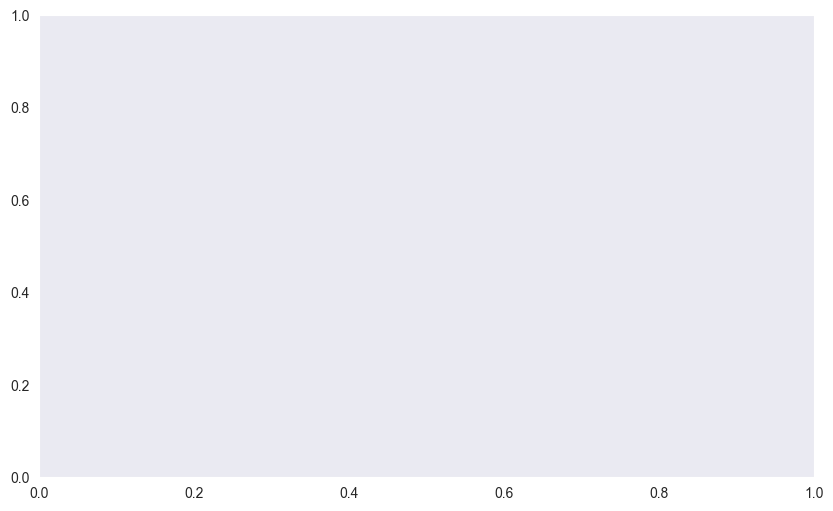

In [127]:
plt.figure(figsize=(10,6))
plt.plot(prof, train_scores, label='Exactitud en entrenamiento', marker='o')
plt.plot(prof, test_scores, label='Exactitud en prueba', marker='o')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Exactitud')
plt.title('Overfitting y Underfitting en Árboles de Decisión')
plt.legend()
plt.grid(True)
plt.show()

#### **4. Optimización de hiperparámetros con RandomizedSearchCV**

In [132]:
arbol = DecisionTreeClassifier(random_state=3)

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': range(5, 51, 1),
    'min_samples_split': range(2, 21, 1)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

random_search = RandomizedSearchCV(
    estimator=arbol,
    param_distributions=param_grid,
    n_iter=5,       
    cv=skf,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Precisión en test:", f1_score(y_test, random_search.predict(X_test), average='macro'))

Mejores hiperparámetros encontrados: {'min_samples_split': 17, 'max_depth': 35, 'criterion': 'entropy'}
Precisión en test: 0.8256302521008403


#### **5. Optimización de hiperparámetros con GridSearchCV**

In [129]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': range(5, 51, 1),
    'min_samples_split': range(2, 21, 1)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(estimator=arbol, param_grid=param_grid, cv=skf, scoring='f1_macro', n_jobs=-1)

# 6. Ajustar modelo
grid_search.fit(X_train, y_train)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Exactitud en test:", f1_score(y_test, grid_search.predict(X_test), average='macro'))

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}
Exactitud en test: 0.8301169590643275


#### **6. Optimización de hiperparámetros con RandomizedSearchCV: Accuracy**

In [130]:
arbol = DecisionTreeClassifier(random_state=3)

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': range(5, 51, 1),
    'min_samples_split': range(2, 21, 1)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

random_search = RandomizedSearchCV(
    estimator=arbol,
    param_distributions=param_grid,
    n_iter=5,       
    cv=skf,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Precisión en test:", accuracy_score(y_test, random_search.predict(X_test)))

Mejores hiperparámetros encontrados: {'min_samples_split': 17, 'max_depth': 35, 'criterion': 'entropy'}
Precisión en test: 0.8313253012048193


#### **7. Optimización de hiperparámetros con GridSearchCV: Accuracy**

In [131]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': range(5, 51, 1),
    'min_samples_split': range(2, 21, 1)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(estimator=arbol, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# 6. Ajustar modelo
grid_search.fit(X_train, y_train)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Exactitud en test:", accuracy_score(y_test, grid_search.predict(X_test)))

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}
Exactitud en test: 0.8313253012048193


#### **8. Actividad de reflexión y análisis**

En este caso, ambos métodos lograron obtener hiperparámetros con casi el mismo mejor puntaje de exactitud. Sin embargo, el menos costoso computacionalmente fue el gridsearch ya que el árbol terminó con una profundidad de 6 contra 35 de RandomizedSearch. Las contrapartes de Accuracy y F1 Score produjeron los mismos parámetros óptimos en ambos métodos.